<a href="https://colab.research.google.com/github/spretosg/PAREUS_PCA/blob/main/PAREUS_optimization_NSGA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial optimisation of protected areas and OECM to rech 30x30 target

This script is a V1.0 implementation that optimises spatial units to improve the existing protected area network in a study area. This routine will be used in the PAREUS project (WP4) taking data from WP2 & WP3. The spatial optimisation is based on a genetic evolutionary algorithm (NSGA3) including many optimisation targets (goals) and different constraints. The script will be the basis for a further implementation into an interactive application at a later stage. The script will cover the following core steps:


1.   Create a study area and planning units (PU) with a specific resolution as spatial data frame
2.   Sample three spatial variables for each PU, based on google earth engine data sets
3. Define and solve an optimization problem
4. Visualize the results

## 1. Study area an PU
We define a test study area and create a grid of planning units (PU). The planning units are the spatial entities that will be optimized towards different goals and constraints.

In [ ]:
#imports
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point # Polygon was imported correctly

# Step 1: Define the coordinates of the study area (example coordinates)
coords = [(10.05, 63.25),  # Southwest corner
    (10.5308, 63.25),  # Southeast corner
    (10.5308, 63.4589),  # Northeast corner
    (10.05, 63.4589),  # Northwest corner
    (10.05, 63.25)]

# Step 2: Create a polygon using shapely
study_area_polygon = Polygon(coords) # No change needed here

# Step 3: Generate a grid of points within the polygon
x_min, y_min, x_max, y_max = study_area_polygon.bounds
grid_spacing = 0.008  # Define the spacing between grid points

x_coords = np.arange(x_min, x_max, grid_spacing)
y_coords = np.arange(y_min, y_max, grid_spacing)
grid_polygons = []
for i in range(len(x_coords)-1):
    for j in range(len(y_coords)-1):
        x1, y1 = x_coords[i], y_coords[j]
        x2, y2 = x_coords[i+1], y_coords[j+1]
        poly_coords = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        grid_polygon = Polygon(poly_coords)
        if study_area_polygon.contains(grid_polygon):
            grid_polygons.append(grid_polygon)

# Step 4: Create a GeoDataFrame to store the grid polygons
grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons, crs="EPSG:4326")



Map the study area

In [ ]:
import folium

center_point = grid_gdf.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)
# Add the selected units to the map
folium.GeoJson(grid_gdf.geometry.to_crs(epsg=4326)).add_to(m)
m

### A routine to exclude/include the already protected areas


## 2. Sample environmental variables

Hereinafter, we sample different environmental variables. These variables will be outputs from WP2 - WP4. In this test case we use the following variables from google earth engine and define it for the optimization problem:


*   Biodiversity integrity --> maximize (not used now)
*   Carbon storage potential --> maximize
*   Elevation --> minimize
*   Population density --> constraint (not used now)
*   Connectivity --> maximize
*   Area protected --> constraint







In [ ]:
import ee ## use earth engine
#ee.Authenticate()
ee.Initialize(project='pareus')
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")



# Function to check for intersection
def check_intersection(geometry):
    # Convert GeoPandas geometry to GeoJSON
    geojson = geometry.__geo_interface__

    # Convert GeoJSON to Earth Engine geometry
    ee_geom = ee.Geometry(geojson)

    # Check for intersection with WDPA
    intersection = wdpa.filterBounds(ee_geom).size().getInfo()

    return intersection > 0

# Apply the function to each geometry in the GeoDataFrame
grid_gdf['intersects_wdpa'] = grid_gdf['geometry'].apply(check_intersection)
# Filter the GeoDataFrame to include only grid cells that do not intersect with protected areas
grid_gdf_filtered = grid_gdf[grid_gdf['intersects_wdpa'] == F]



In [ ]:
# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)
folium.GeoJson(grid_gdf_filtered.geometry.to_crs(epsg=4326)).add_to(m)
m

In [ ]:

elevation_data = ee.Image('USGS/GMTED2010_FULL')

# Define a function to sample elevation for each polygon
def sample_elevation(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean elevation within the polygon
    mean_elevation = elevation_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_polygon,
        scale=30  # Adjust scale as needed
    ).get('be75')

    return mean_elevation.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
grid_gdf['mean_elevation'] = grid_gdf['geometry'].apply(sample_elevation)



In [ ]:
print(grid_gdf)

      level_0  index                                           geometry  \
0           0      0  POLYGON ((10.05000 63.25000, 10.05800 63.25000...   
1           1      1  POLYGON ((10.05000 63.25800, 10.05800 63.25800...   
2           2      2  POLYGON ((10.05000 63.26600, 10.05800 63.26600...   
3           3      3  POLYGON ((10.05000 63.27400, 10.05800 63.27400...   
4           4      4  POLYGON ((10.05000 63.28200, 10.05800 63.28200...   
...       ...    ...                                                ...   
1390     1390   1390  POLYGON ((10.52200 63.39400, 10.53000 63.39400...   
1391     1391   1391  POLYGON ((10.52200 63.40200, 10.53000 63.40200...   
1392     1392   1392  POLYGON ((10.52200 63.41000, 10.53000 63.41000...   
1393     1393   1393  POLYGON ((10.52200 63.41800, 10.53000 63.41800...   
1394     1394   1394  POLYGON ((10.52200 63.42600, 10.53000 63.42600...   

      mean_elevation  mean_biodiversity   mean_co      area  rel_occ_paropt3  \
0           0.17825

In [ ]:
## biodiversity

bdi_ic = ee.ImageCollection("projects/ebx-data/assets/earthblox/IO/BIOINTACT").mean()
#bdi_2017_20_comp = bdi_ic.mean()
#bdi_2017_comp = bdi_ic.filterDate('2017-01-01', '2017-12-31').mean()

# Define a function to sample bii for each polygon
def sample_bii(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean bii within the polygon
    mean_bii = bdi_ic.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_polygon,
        scale=30  # Adjust scale as needed
    ).get('BioIntactness')

    return mean_bii.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
grid_gdf['mean_biodiversity'] = grid_gdf['geometry'].apply(sample_bii)

In [ ]:
## carbon density [CO t/ha]

co = ee.Image('WCMC/biomass_carbon_density/v1_0/2010')
# Define a function to sample carbon for each polygon
def sample_co(polygon):
    # Convert shapely polygon to Earth Engine geometry
    # Convert the list of tuples to a list of lists
    ee_polygon = ee.Geometry.Polygon([[list(coord) for coord in polygon.exterior.coords]])

    # Calculate the mean co within the polygon
    mean_co = co.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee_polygon,
        scale=30  # Adjust scale as needed
    ).get('carbon_tonnes_per_ha')

    return mean_co.getInfo()

# Apply the sampling function to each polygon in the GeoDataFrame
grid_gdf['mean_co'] = grid_gdf['geometry'].apply(sample_co)

In [ ]:
## normalize data
# Function to normalize a column between 0 and 1
def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize the selected columns
columns_to_normalize = ['mean_elevation', 'mean_biodiversity', 'mean_co']
for col in columns_to_normalize:
    grid_gdf[col] = normalize_column(grid_gdf[col])

In [ ]:
# calculate the area for each grid cell
grid_gdf_projected = grid_gdf.to_crs('EPSG:3035')
grid_gdf['area'] = grid_gdf_projected.geometry.area/1000000

## drop possible NaN
grid_gdf = grid_gdf.dropna()

## 3. Define an optimization problem
Based on the sampled data, a spatial optimization problem will be defined (just a sample problem):


*   Minimize the elevation of the PU's to avoid remote areas in the mountains
*   Maximize the biodiversity intactness index
*   Maximize connectivity between PU's

Constraints:
*   Define a total km2 area that should be protected

The user can add a weight to the optimization goals to develop different scenarios.



In [ ]:
#optim package pymoo
#!pip install pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from shapely.ops import unary_union


In [ ]:
class SpatialOptimizationProblem(Problem):
    def __init__(self, grid_gdf, min_area, w1, w2, w3):
        super().__init__(n_var=len(grid_gdf),
                         n_obj=4,
                         n_ieq_constr=1,
                         xl=0,
                         xu=1,
                         type_var=bool)
        self.features = grid_gdf
        self.min_area = min_area # Add min_area as an attribute
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def _evaluate(self, x, out, *args, **kwargs):
        elevation = self.features['mean_elevation'].values
        biodiversity = self.features['mean_biodiversity'].values
        carbon = self.features['mean_co'].values
        area = self.features['area'].values

        # Objective 1: Minimize elevation
        f1 = self.w1 * np.sum(x * elevation, axis=1)

        # Objective 2: Maximize biodiversity
        f2 = self.w2 * -np.sum(x * biodiversity, axis=1)

        #Objective 3: Maximize carbon storage potential
        f3 = self.w3 * -np.sum(x * carbon, axis=1)

        # Objective 4: Maximize connectivity (was g2)
        f4 = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            selected_units = self.features.iloc[np.where(x[i] == 1)[0]]
            if not selected_units.empty:
                merged_geom = unary_union(selected_units.geometry)
                if hasattr(merged_geom, 'geoms'):
                    f3[i] = -len(selected_units) + len(merged_geom.geoms) # Minimize number of components
                else:
                    f3[i] = 0  # Single polygon, fully connected

        out["F"] = np.column_stack([f1, f2, f3, f4])

        # Constraint 1: Total cost should not exceed max_cost (e.g. 10000)
        g1 = self.min_area - np.sum(x * area, axis=1)

        out["G"] = [g1]




In [ ]:
min_area = 10 #km2
problem = SpatialOptimizationProblem(grid_gdf, min_area, 0.3,0.2,0.5)

## here we can make two problems, one with, and one without the connectivity

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=12)

algorithm = NSGA3(
    pop_size=120,
    n_offsprings=10,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    ref_dirs=ref_dirs
)

This might cause unwanted behavior of the algorithm. 
Please make sure pop_size is equal or larger than the number of reference directions. 


In [ ]:
## optimization follows here:
from pymoo.termination import get_termination
import pandas as pd

termination = get_termination("n_gen", 150)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

unit_counts = {}
for i in range(len(grid_gdf)):
    unit_counts[i] = 0

# Iterate through the optimal solutions
for solution in res.X:
    # Get indices of selected units (assuming binary solutions)
    selected_indices = np.where(solution == 1)[0]
    # Increment counts for selected units
    for idx in selected_indices:
        unit_counts[idx] += 1

# Print the counts
#for unit_id, count in unit_counts.items():
#    print(f"Planning Unit {unit_id}: {count} occurrences")

count_series = pd.Series({k: v / len(res.G) for k, v in unit_counts.items()}, name='rel_occ_paropt4')
grid_gdf = grid_gdf.reset_index(drop=True)  # Drop the old index
grid_gdf = grid_gdf.join(count_series)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      120 |     10 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      130 |     12 |  0.000000E+00 |  0.000000E+00 |  0.5771151541 |         ideal
     3 |      140 |     11 |  0.000000E+00 |  0.000000E+00 |  0.2572572008 |         ideal
     4 |      150 |     11 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      160 |     15 |  0.000000E+00 |  0.000000E+00 |  0.2213427344 |         ideal
     6 |      170 |     14 |  0.000000E+00 |  0.000000E+00 |  0.1342360161 |         ideal
     7 |      180 |     15 |  0.000000E+00 |  0.000000E+00 |  0.1183492802 |         ideal
     8 |      190 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0402291444 |             f
     9 |      200 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0461599066 |             f
    10 |      210 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0259987394 |             f

## 4. Visualize the optimization results

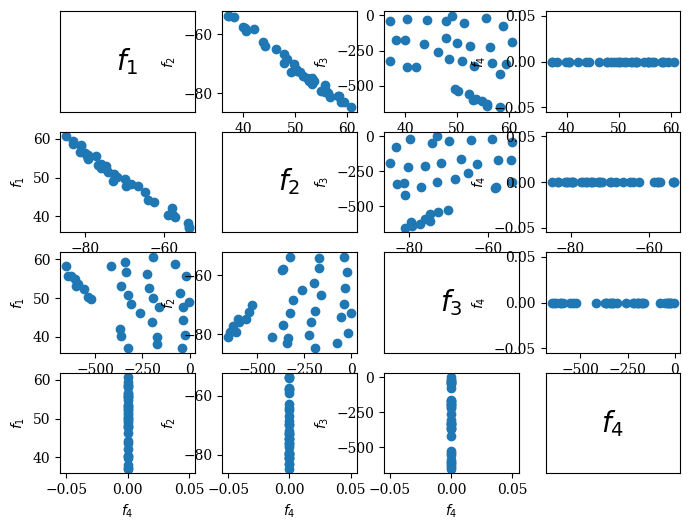

In [ ]:
plot = Scatter()
plot.add(res.F)
#print(res.F)
plot.show()

Here single optimal solutions of each iteration can be visualized. Adjust the index manually.

In [ ]:
index = 110 # which of the iterations to display
# Iterate through each solution in the population
for solution in res.history[index].pop.get("X"):
    # Get the indices of the selected features
    selected_indices = np.where(solution == 1)[0]

    # Filter the features GeoDataFrame
    selected_features = grid_gdf.iloc[selected_indices]

    # Print or process the selected features for this solution
print(selected_features)
center_point = selected_features.geometry.unary_union.centroid.coords[0][::-1] # reverse coordinates for folium

# Create a folium map centered on the selected units
m = folium.Map(location=center_point, zoom_start=10)

# Add the selected units to the map
folium.GeoJson(selected_features.geometry.to_crs(epsg=4326)).add_to(m)

# Display the map
m


      level_0  index                                           geometry  \
25         25     25  POLYGON ((10.05800 63.33000, 10.06600 63.33000...   
33         33     33  POLYGON ((10.06600 63.27400, 10.07400 63.27400...   
68         68     68  POLYGON ((10.08200 63.30600, 10.09000 63.30600...   
143       143    143  POLYGON ((10.11400 63.31400, 10.12200 63.31400...   
159       159    159  POLYGON ((10.12200 63.28200, 10.13000 63.28200...   
...       ...    ...                                                ...   
1314     1314   1314  POLYGON ((10.49800 63.35400, 10.50600 63.35400...   
1319     1319   1319  POLYGON ((10.49800 63.39400, 10.50600 63.39400...   
1343     1343   1343  POLYGON ((10.50600 63.39400, 10.51400 63.39400...   
1366     1366   1366  POLYGON ((10.51400 63.38600, 10.52200 63.38600...   
1373     1373   1373  POLYGON ((10.52200 63.25800, 10.53000 63.25800...   

      mean_elevation  mean_biodiversity   mean_co      area  rel_occ_paropt3  \
25          0.07198

In [ ]:
# prompt: take the rel_occ_paropt3 col of the grid_gdf and visualize it on the map with a color

import folium

# Define the color map
color_map = 'YlGn'

# Set the threshold
threshold = 0.4  # Replace with your desired threshold value

# Filter the GeoDataFrame
filtered_gdf = grid_gdf[grid_gdf['rel_occ_paropt4'] > threshold]

# Create a new column for the color values
filtered_gdf['color_value'] = filtered_gdf['rel_occ_paropt4']

# Create a map centered on the study area
center_point = filtered_gdf.geometry.unary_union.centroid.coords[0][::-1]
m = folium.Map(location=center_point, zoom_start=10)

# Reset the index of the GeoDataFrame to create an 'index' column
#filtered_gdf = filtered_gdf.reset_index()

# Add a choropleth layer to the map
folium.Choropleth(
    geo_data=filtered_gdf.to_json(),
    data=filtered_gdf,
    columns=['index', 'color_value'],
    key_on='feature.properties.index',
    fill_color=color_map,
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Relative occurence in pareto solutions'
).add_to(m)

# Display the map
m
